In [1]:
import pandas as pd
import numpy as np
import os
import json
import itertools as it
import time
import subprocess
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from datetime import date, datetime, timedelta
from tensorflow import keras
from keras.layers import LSTM, SimpleRNN, GRU
from sklearn.metrics import confusion_matrix,classification_report,ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, average_precision_score
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from keras.utils import plot_model
from transformers import BertTokenizer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

2024-04-13 16:20:50.530605: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-13 16:20:50.561139: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-13 16:20:51.130180: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
majestic = pd.read_csv('./treino/majestic_ascii.csv')
majestic['69'] = 0
majestic['70'] = 0
majestic['71'] = 0
majestic

,domain,label,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
0,google.com,0,103,111,111,103,108,101,46,99,...,0,0,0,0,0,0,0,0,0,0
1,facebook.com,0,102,97,99,101,98,111,111,107,...,0,0,0,0,0,0,0,0,0,0
2,youtube.com,0,121,111,117,116,117,98,101,46,...,0,0,0,0,0,0,0,0,0,0
3,twitter.com,0,116,119,105,116,116,101,114,46,...,0,0,0,0,0,0,0,0,0,0
4,instagram.com,0,105,110,115,116,97,103,114,97,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,fidgit.com,0,102,105,100,103,105,116,46,99,...,0,0,0,0,0,0,0,0,0,0
999996,fixwindows10connections.com,0,102,105,120,119,105,110,100,111,...,0,0,0,0,0,0,0,0,0,0
999997,flyerguide.com,0,102,108,121,101,114,103,117,105,...,0,0,0,0,0,0,0,0,0,0
999998,forwardpathway.com,0,102,111,114,119,97,114,100,112,...,0,0,0,0,0,0,0,0,0,0


In [3]:
dga = pd.read_csv('./treino/df_train.csv')
dga = dga.drop('family', axis = 1)
dga

,domain,label,3,4,5,6,7,8,9,10,...,63,64,65,66,67,68,69,70,71,72
0,uzwdmrlhr.tk,1,117,122,119,100,109,114,108,104,...,0,0,0,0,0,0,0,0,0,0
1,uzwdmrlhr.com,1,117,122,119,100,109,114,108,104,...,0,0,0,0,0,0,0,0,0,0
2,uzwdmrlhr.pages.dev,1,117,122,119,100,109,114,108,104,...,0,0,0,0,0,0,0,0,0,0
3,rhrlwdumz.tk,1,114,104,114,108,119,100,117,109,...,0,0,0,0,0,0,0,0,0,0
4,rhrlwdumz.com,1,114,104,114,108,119,100,117,109,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1352254,kwgjjpbcaaanbivklyxx.com,1,107,119,103,106,106,112,98,99,...,0,0,0,0,0,0,0,0,0,0
1352255,vxijfvgvihjnfvofxmyc.com,1,118,120,105,106,102,118,103,118,...,0,0,0,0,0,0,0,0,0,0
1352256,cepswmbgtknhtkhlsecg.com,1,99,101,112,115,119,109,98,103,...,0,0,0,0,0,0,0,0,0,0
1352257,tifjhjtouqmdlbkfnuow.com,1,116,105,102,106,104,106,116,111,...,0,0,0,0,0,0,0,0,0,0


In [4]:
dga.columns = majestic.columns

In [5]:
dga = dga.loc[~dga['domain'].isin(majestic['domain'])].reset_index(drop=True)

In [6]:
dga = pd.concat([majestic,dga], axis = 0, ignore_index=True)

In [7]:
df_train,df_test = train_test_split(dga, test_size=0.3, random_state=1, shuffle=True)

In [8]:
df_train.groupby('label').count()

,domain,2,3,4,5,6,7,8,9,10,...,62,63,64,65,66,67,68,69,70,71
label,,,,,,,,,,,,,,,,,,,,,
0,700179,700179,700179,700179,700179,700179,700179,700179,700179,700179,...,700179,700179,700179,700179,700179,700179,700179,700179,700179,700179
1,946365,946365,946365,946365,946365,946365,946365,946365,946365,946365,...,946365,946365,946365,946365,946365,946365,946365,946365,946365,946365


In [9]:
df_test.groupby('label').count()

,domain,2,3,4,5,6,7,8,9,10,...,62,63,64,65,66,67,68,69,70,71
label,,,,,,,,,,,,,,,,,,,,,
0,299821,299821,299821,299821,299821,299821,299821,299821,299821,299821,...,299821,299821,299821,299821,299821,299821,299821,299821,299821,299821
1,405842,405842,405842,405842,405842,405842,405842,405842,405842,405842,...,405842,405842,405842,405842,405842,405842,405842,405842,405842,405842


In [10]:
X_train = df_train.drop(['domain','label'], axis = 1)
y_train = df_train['label']

X_test = df_test.drop(['domain','label'], axis = 1)
y_test = df_test['label']

In [11]:
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()

X_test = X_test.to_numpy()
y_test = y_test.to_numpy()

In [12]:
X_train.shape, X_test.shape

((1646544, 70), (705663, 70))

In [13]:
#Carregando hyperparâmetros de regularizadores, otimizador e função de ativação
l1l2 = keras.regularizers.l1_l2(l1=0.00001, l2=0.0001)
opt = keras.optimizers.Adam(learning_rate=0.0001)
fx = "relu"

2024-04-10 14:30:53.538687: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-10 14:30:53.582817: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-10 14:30:53.582966: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

## Modelo 1

In [14]:
#Estrutura do modelo convolucional profundo
model_1 = tf.keras.Sequential([
      
        layers.Embedding(input_dim=256,output_dim=60,input_length=70),
    
        layers.Conv1D(500, 7, activation=fx, activity_regularizer=l1l2, padding='same'),
        layers.ReLU(),
            
        layers.Conv1D(250, 6, activation=fx, activity_regularizer=l1l2, padding='same'),
        layers.ReLU(),
        layers.MaxPooling1D(pool_size=6, strides=1, padding='same'),
    
        layers.Conv1D(120, 5, activation=fx, activity_regularizer=l1l2, padding='same'),
        layers.ReLU(),
    
        layers.Conv1D(60, 5, activation=fx, activity_regularizer=l1l2, padding='same'),
        layers.ReLU(),
        layers.MaxPooling1D(pool_size=4, strides=1, padding='same'),
    
        layers.Conv1D(30, 4, activation=fx, activity_regularizer=l1l2, padding='same'),
        layers.ReLU(),
    
        layers.Conv1D(30, 3, activation=fx, activity_regularizer=l1l2, padding='same'),
        layers.ReLU(),
        layers.MaxPooling1D(pool_size=3, strides=1, padding='same'),
    
        layers.Flatten(),
        layers.Dense(15, activation=fx, activity_regularizer=l1l2),
        layers.Dense(1, activation='sigmoid')])

model_1.compile(optimizer = opt, loss = 'binary_crossentropy', metrics='accuracy')
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 70, 60)            15360     
                                                                 
 conv1d (Conv1D)             (None, 70, 500)           210500    
                                                                 
 re_lu (ReLU)                (None, 70, 500)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 70, 250)           750250    
                                                                 
 re_lu_1 (ReLU)              (None, 70, 250)           0         
                                                                 
 max_pooling1d (MaxPooling1  (None, 70, 250)           0         
 D)                                                              
                                                        

In [15]:
best11 = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model11',
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [14]:
# Ajustando uso de memoria RAM e GPU
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  pass

In [27]:
model_1.fit(X_train1, y_train1,
              epochs=10,
              validation_split = 0.1,
              callbacks = [best11],
              batch_size=200)

Epoch 1/10


2024-04-10 08:19:20.690771: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8902
2024-04-10 08:19:21.342764: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-04-10 08:19:21.344925: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5c1a15d95810 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-10 08:19:21.344937: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2024-04-10 08:19:21.348546: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-10 08:19:21.432124: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifeti

7410/7410 [==============================] - ETA: 0s - loss: 0.1078 - accuracy: 0.9607

2024-04-10 08:24:05.624739: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.73GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-04-10 08:24:05.630357: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.73GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


INFO:tensorflow:Assets written to: best_model11/assets


INFO:tensorflow:Assets written to: best_model11/assets


7410/7410 [==============================] - 298s 40ms/step - loss: 0.1078 - accuracy: 0.9607 - val_loss: 0.0709 - val_accuracy: 0.9757
Epoch 2/10
7410/7410 [==============================] - ETA: 0s - loss: 0.0629 - accuracy: 0.9785INFO:tensorflow:Assets written to: best_model11/assets


INFO:tensorflow:Assets written to: best_model11/assets


7410/7410 [==============================] - 289s 39ms/step - loss: 0.0629 - accuracy: 0.9785 - val_loss: 0.0629 - val_accuracy: 0.9782
Epoch 3/10
7410/7410 [==============================] - ETA: 0s - loss: 0.0508 - accuracy: 0.9828INFO:tensorflow:Assets written to: best_model11/assets


INFO:tensorflow:Assets written to: best_model11/assets


7410/7410 [==============================] - 288s 39ms/step - loss: 0.0508 - accuracy: 0.9828 - val_loss: 0.0611 - val_accuracy: 0.9784
Epoch 4/10
7409/7410 [============================>.] - ETA: 0s - loss: 0.0426 - accuracy: 0.9856INFO:tensorflow:Assets written to: best_model11/assets


INFO:tensorflow:Assets written to: best_model11/assets


7410/7410 [==============================] - 288s 39ms/step - loss: 0.0426 - accuracy: 0.9856 - val_loss: 0.0612 - val_accuracy: 0.9788
Epoch 5/10
7410/7410 [==============================] - 287s 39ms/step - loss: 0.0361 - accuracy: 0.9880 - val_loss: 0.0645 - val_accuracy: 0.9785
Epoch 6/10
7409/7410 [============================>.] - ETA: 0s - loss: 0.0306 - accuracy: 0.9900INFO:tensorflow:Assets written to: best_model11/assets


INFO:tensorflow:Assets written to: best_model11/assets


7410/7410 [==============================] - 288s 39ms/step - loss: 0.0306 - accuracy: 0.9900 - val_loss: 0.0626 - val_accuracy: 0.9796
Epoch 7/10
7410/7410 [==============================] - 287s 39ms/step - loss: 0.0261 - accuracy: 0.9915 - val_loss: 0.0655 - val_accuracy: 0.9788
Epoch 8/10
7410/7410 [==============================] - 287s 39ms/step - loss: 0.0223 - accuracy: 0.9929 - val_loss: 0.0725 - val_accuracy: 0.9789
Epoch 9/10
7410/7410 [==============================] - 288s 39ms/step - loss: 0.0191 - accuracy: 0.9940 - val_loss: 0.0733 - val_accuracy: 0.9785
Epoch 10/10
7410/7410 [==============================] - 290s 39ms/step - loss: 0.0165 - accuracy: 0.9950 - val_loss: 0.0754 - val_accuracy: 0.9792


In [17]:
model_1 = tf.keras.models.load_model('best_model11')

In [18]:
predictions = model_1.predict(X_test)
predictions = np.where(predictions > 0.5, 1, 0)

print('Matriz de Confusão')
print(confusion_matrix(y_test,predictions))

print('Relatório de Classificação')
print(classification_report(y_test,predictions, digits=4))

2024-04-10 09:16:25.961880: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8902


   73/22052 [..............................] - ETA: 46s  

2024-04-10 09:16:26.405279: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


22052/22052 [==============================] - 47s 2ms/step
Matriz de Confusão
[[292883   6938]
 [  7183 398659]]
Relatório de Classificação
              precision    recall  f1-score   support

           0     0.9761    0.9769    0.9765    299821
           1     0.9829    0.9823    0.9826    405842

    accuracy                         0.9800    705663
   macro avg     0.9795    0.9796    0.9795    705663
weighted avg     0.9800    0.9800    0.9800    705663



## Modelo 2

In [15]:
#Estrutura do modelo convolucional profundo
model_2 = tf.keras.Sequential([
      
        layers.Embedding(input_dim=256,output_dim=60,input_length=70),
    
        layers.Conv1D(500, 7, activation=fx, activity_regularizer=l1l2, padding='same'),
        #layers.ReLU(),
            
        layers.Conv1D(250, 6, activation=fx, activity_regularizer=l1l2, padding='same'),
        #layers.ReLU(),
        #layers.MaxPooling1D(pool_size=6, strides=1, padding='same'),
    
        layers.Conv1D(120, 5, activation=fx, activity_regularizer=l1l2, padding='same'),
        #layers.ReLU(),
    
        layers.Conv1D(60, 5, activation=fx, activity_regularizer=l1l2, padding='same'),
        #layers.ReLU(),
        #layers.MaxPooling1D(pool_size=4, strides=1, padding='same'),
    
        layers.Conv1D(30, 4, activation=fx, activity_regularizer=l1l2, padding='same'),
        #layers.ReLU(),
    
        layers.Conv1D(30, 3, activation=fx, activity_regularizer=l1l2, padding='same'),
        #layers.ReLU(),
        #layers.MaxPooling1D(pool_size=3, strides=1, padding='same'),
    
        layers.Flatten(),
        layers.Dense(15, activation=fx, activity_regularizer=l1l2),
        layers.Dense(1, activation='sigmoid')])

model_2.compile(optimizer = opt, loss = 'binary_crossentropy', metrics='accuracy')
model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 70, 60)            15360     
                                                                 
 conv1d (Conv1D)             (None, 70, 500)           210500    
                                                                 
 conv1d_1 (Conv1D)           (None, 70, 250)           750250    
                                                                 
 conv1d_2 (Conv1D)           (None, 70, 120)           150120    
                                                                 
 conv1d_3 (Conv1D)           (None, 70, 60)            36060     
                                                                 
 conv1d_4 (Conv1D)           (None, 70, 30)            7230      
                                                                 
 conv1d_5 (Conv1D)           (None, 70, 30)            2

In [16]:
best21 = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model21',
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [17]:
model_2.fit(X_train, y_train,
              epochs=10,
              validation_split = 0.1,
              callbacks = [best21],
              batch_size=200)

Epoch 1/10


2024-04-10 09:24:06.688514: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8902
2024-04-10 09:24:07.328327: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-04-10 09:24:07.330776: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7959b0002a40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-10 09:24:07.330792: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2024-04-10 09:24:07.334570: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-10 09:24:07.414341: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifeti

7410/7410 [==============================] - ETA: 0s - loss: 0.1162 - accuracy: 0.9579

2024-04-10 09:28:21.797507: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.73GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-04-10 09:28:21.803091: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.73GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


INFO:tensorflow:Assets written to: best_model21/assets


INFO:tensorflow:Assets written to: best_model21/assets


7410/7410 [==============================] - 266s 35ms/step - loss: 0.1162 - accuracy: 0.9579 - val_loss: 0.0751 - val_accuracy: 0.9747
Epoch 2/10
7409/7410 [============================>.] - ETA: 0s - loss: 0.0679 - accuracy: 0.9769INFO:tensorflow:Assets written to: best_model21/assets


INFO:tensorflow:Assets written to: best_model21/assets


7410/7410 [==============================] - 257s 35ms/step - loss: 0.0679 - accuracy: 0.9769 - val_loss: 0.0682 - val_accuracy: 0.9759
Epoch 3/10
7409/7410 [============================>.] - ETA: 0s - loss: 0.0546 - accuracy: 0.9815INFO:tensorflow:Assets written to: best_model21/assets


INFO:tensorflow:Assets written to: best_model21/assets


7410/7410 [==============================] - 258s 35ms/step - loss: 0.0546 - accuracy: 0.9815 - val_loss: 0.0607 - val_accuracy: 0.9795
Epoch 4/10
7409/7410 [============================>.] - ETA: 0s - loss: 0.0452 - accuracy: 0.9847INFO:tensorflow:Assets written to: best_model21/assets


INFO:tensorflow:Assets written to: best_model21/assets


7410/7410 [==============================] - 259s 35ms/step - loss: 0.0452 - accuracy: 0.9847 - val_loss: 0.0587 - val_accuracy: 0.9798
Epoch 5/10
7410/7410 [==============================] - 258s 35ms/step - loss: 0.0373 - accuracy: 0.9876 - val_loss: 0.0614 - val_accuracy: 0.9793
Epoch 6/10
7410/7410 [==============================] - 259s 35ms/step - loss: 0.0308 - accuracy: 0.9900 - val_loss: 0.0636 - val_accuracy: 0.9790
Epoch 7/10
7410/7410 [==============================] - 260s 35ms/step - loss: 0.0254 - accuracy: 0.9919 - val_loss: 0.0745 - val_accuracy: 0.9782
Epoch 8/10
7410/7410 [==============================] - 258s 35ms/step - loss: 0.0212 - accuracy: 0.9934 - val_loss: 0.0711 - val_accuracy: 0.9788
Epoch 9/10
7410/7410 [==============================] - 257s 35ms/step - loss: 0.0181 - accuracy: 0.9945 - val_loss: 0.0766 - val_accuracy: 0.9780
Epoch 10/10
7410/7410 [==============================] - 258s 35ms/step - loss: 0.0155 - accuracy: 0.9953 - val_loss: 0.0766 - va

In [18]:
model_2 = tf.keras.models.load_model('best_model21')

In [19]:
predictions = model_2.predict(X_test)
predictions = np.where(predictions > 0.5, 1, 0)

print('Matriz de Confusão')
print(confusion_matrix(y_test,predictions))

print('Relatório de Classificação')
print(classification_report(y_test,predictions, digits=4))

22052/22052 [==============================] - 43s 2ms/step
Matriz de Confusão
[[292879   6942]
 [  7239 398603]]
Relatório de Classificação
              precision    recall  f1-score   support

           0     0.9759    0.9768    0.9764    299821
           1     0.9829    0.9822    0.9825    405842

    accuracy                         0.9799    705663
   macro avg     0.9794    0.9795    0.9794    705663
weighted avg     0.9799    0.9799    0.9799    705663



## Modelo 3

In [14]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [15]:
#Estrutura do modelo convolucional profundo
model_3 = tf.keras.Sequential([
      
        layers.Input(shape=(X_train.shape[1],X_train.shape[2])),
    
        layers.Conv1D(500, 7, activation=fx, activity_regularizer=l1l2, padding='same'),
        layers.ReLU(),
            
        layers.Conv1D(250, 6, activation=fx, activity_regularizer=l1l2, padding='same'),
        layers.ReLU(),
        layers.MaxPooling1D(pool_size=6, strides=1, padding='same'),
    
        layers.Conv1D(120, 5, activation=fx, activity_regularizer=l1l2, padding='same'),
        layers.ReLU(),
    
        layers.Conv1D(60, 5, activation=fx, activity_regularizer=l1l2, padding='same'),
        layers.ReLU(),
        layers.MaxPooling1D(pool_size=4, strides=1, padding='same'),
    
        layers.Conv1D(30, 4, activation=fx, activity_regularizer=l1l2, padding='same'),
        layers.ReLU(),
    
        layers.Conv1D(30, 3, activation=fx, activity_regularizer=l1l2, padding='same'),
        layers.ReLU(),
        layers.MaxPooling1D(pool_size=3, strides=1, padding='same'),
    
        layers.Flatten(),
        layers.Dense(15, activation=fx, activity_regularizer=l1l2),
        layers.Dense(1, activation='sigmoid')])

model_3.compile(optimizer = opt, loss = 'binary_crossentropy', metrics='accuracy')
model_3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 70, 500)           4000      
                                                                 
 re_lu (ReLU)                (None, 70, 500)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 70, 250)           750250    
                                                                 
 re_lu_1 (ReLU)              (None, 70, 250)           0         
                                                                 
 max_pooling1d (MaxPooling1  (None, 70, 250)           0         
 D)                                                              
                                                                 
 conv1d_2 (Conv1D)           (None, 70, 120)           150120    
                                                        

In [16]:
best31 = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model31',
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [17]:
model_3.fit(X_train, y_train,
              epochs=10,
              validation_split = 0.1,
              callbacks = [best31],
              batch_size=200)

Epoch 1/10


2024-04-10 10:16:07.678209: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8902
2024-04-10 10:16:08.252077: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-04-10 10:16:08.254196: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5d4cbbf73700 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-10 10:16:08.254209: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2024-04-10 10:16:08.257850: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-10 10:16:08.337535: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifeti

7409/7410 [============================>.] - ETA: 0s - loss: 0.5356 - accuracy: 0.8476

2024-04-10 10:20:19.781725: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.53GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-04-10 10:20:19.781767: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.53GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


7410/7410 [==============================] - ETA: 0s - loss: 0.5356 - accuracy: 0.8476

2024-04-10 10:20:20.788327: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.55GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-04-10 10:20:21.490875: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.73GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-04-10 10:20:21.496431: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.73GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


INFO:tensorflow:Assets written to: best_model31/assets


INFO:tensorflow:Assets written to: best_model31/assets


7410/7410 [==============================] - 265s 35ms/step - loss: 0.5356 - accuracy: 0.8476 - val_loss: 0.3063 - val_accuracy: 0.8760
Epoch 2/10
7409/7410 [============================>.] - ETA: 0s - loss: 0.2947 - accuracy: 0.8798INFO:tensorflow:Assets written to: best_model31/assets


INFO:tensorflow:Assets written to: best_model31/assets


7410/7410 [==============================] - 259s 35ms/step - loss: 0.2947 - accuracy: 0.8798 - val_loss: 0.2707 - val_accuracy: 0.8915
Epoch 3/10
7410/7410 [==============================] - 258s 35ms/step - loss: 0.2709 - accuracy: 0.8904 - val_loss: 0.2987 - val_accuracy: 0.8770
Epoch 4/10
7409/7410 [============================>.] - ETA: 0s - loss: 0.2575 - accuracy: 0.8962INFO:tensorflow:Assets written to: best_model31/assets


INFO:tensorflow:Assets written to: best_model31/assets


7410/7410 [==============================] - 259s 35ms/step - loss: 0.2575 - accuracy: 0.8962 - val_loss: 0.2475 - val_accuracy: 0.9011
Epoch 5/10
7410/7410 [==============================] - 258s 35ms/step - loss: 0.2471 - accuracy: 0.9012 - val_loss: 0.2646 - val_accuracy: 0.8928
Epoch 6/10
7410/7410 [==============================] - 258s 35ms/step - loss: 0.2391 - accuracy: 0.9048 - val_loss: 0.2688 - val_accuracy: 0.8897
Epoch 7/10
7409/7410 [============================>.] - ETA: 0s - loss: 0.2325 - accuracy: 0.9078INFO:tensorflow:Assets written to: best_model31/assets


INFO:tensorflow:Assets written to: best_model31/assets


7410/7410 [==============================] - 259s 35ms/step - loss: 0.2325 - accuracy: 0.9078 - val_loss: 0.2321 - val_accuracy: 0.9082
Epoch 8/10
7409/7410 [============================>.] - ETA: 0s - loss: 0.2278 - accuracy: 0.9099INFO:tensorflow:Assets written to: best_model31/assets


INFO:tensorflow:Assets written to: best_model31/assets


7410/7410 [==============================] - 259s 35ms/step - loss: 0.2278 - accuracy: 0.9099 - val_loss: 0.2211 - val_accuracy: 0.9143
Epoch 9/10
7409/7410 [============================>.] - ETA: 0s - loss: 0.2229 - accuracy: 0.9120INFO:tensorflow:Assets written to: best_model31/assets


INFO:tensorflow:Assets written to: best_model31/assets


7410/7410 [==============================] - 259s 35ms/step - loss: 0.2229 - accuracy: 0.9120 - val_loss: 0.2161 - val_accuracy: 0.9158
Epoch 10/10
7410/7410 [==============================] - 258s 35ms/step - loss: 0.2186 - accuracy: 0.9140 - val_loss: 0.2197 - val_accuracy: 0.9135


In [18]:
model_3 = tf.keras.models.load_model('best_model31')

In [19]:
predictions = model_3.predict(X_test)
predictions = np.where(predictions > 0.5, 1, 0)

print('Matriz de Confusão')
print(confusion_matrix(y_test,predictions))

print('Relatório de Classificação')
print(classification_report(y_test,predictions, digits=4))

22052/22052 [==============================] - 43s 2ms/step
Matriz de Confusão
[[265703  34118]
 [ 25522 380320]]
Relatório de Classificação
              precision    recall  f1-score   support

           0     0.9124    0.8862    0.8991    299821
           1     0.9177    0.9371    0.9273    405842

    accuracy                         0.9155    705663
   macro avg     0.9150    0.9117    0.9132    705663
weighted avg     0.9154    0.9155    0.9153    705663



## Bilbo

In [20]:
MAX_INDEX = 70 # Max number of valid characters in a domain
MAX_STRING_LENGTH = 63
EMBEDDING_DIMENSION = 128
NUM_CONV_FILTERS = 60

#Carregando hyperparâmetros de regularizadores, otimizador e função de ativação
l1l2 = keras.regularizers.l1_l2(l1=0.00001, l2=0.0001)
opt = keras.optimizers.legacy.Adam(learning_rate=0.0001)
fx = "relu"

In [24]:
input = layers.Input((70,), dtype='int32', name="input")

########################
#          CNN         #
########################

embeddingCNN = layers.Embedding(
                        output_dim=EMBEDDING_DIMENSION, 
                        input_dim=MAX_INDEX,
                        input_length=MAX_STRING_LENGTH, 
                        name="embeddingCNN")(input)

# Parallel Convolutional Layer

conv2 = layers.Conv1D(NUM_CONV_FILTERS, 2, name="conv2") (embeddingCNN)

conv3 = layers.Conv1D(NUM_CONV_FILTERS, 3, name="conv3") (embeddingCNN)

conv4 = layers.Conv1D(NUM_CONV_FILTERS, 4, name="conv4") (embeddingCNN)

conv5 = layers.Conv1D(NUM_CONV_FILTERS, 5, name="conv5") (embeddingCNN)

conv6 = layers.Conv1D(NUM_CONV_FILTERS, 6, name="conv6") (embeddingCNN)

# Global max pooling

pool2 = layers.GlobalMaxPool1D(name="pool2") (conv2)

pool3 = layers.GlobalMaxPool1D(name="pool3") (conv3)

pool4 = layers.GlobalMaxPool1D(name="pool4") (conv4)

pool5 = layers.GlobalMaxPool1D(name="pool5") (conv5)

pool6 = layers.GlobalMaxPool1D(name="pool6") (conv6)


concatcnn = layers.Concatenate(axis=1)([pool2,pool3, pool4, pool5, pool6])


dropoutcnnmid = layers.Dropout(0.5, name="dropoutcnnmid")(concatcnn)

densecnn = layers.Dense(NUM_CONV_FILTERS, activation="relu",
                        name="densecnn")(dropoutcnnmid)

dropoutcnn = layers.Dropout(0.5, name="dropoutcnn") (densecnn)

########################
#         LSTM         #
########################

embeddingLSTM = layers.Embedding(output_dim=20, 
                             input_dim=256,
                             input_length=MAX_STRING_LENGTH, 
                             name="embeddingLSTM") (input)


lstm = layers.LSTM(256, name="lstm")(embeddingLSTM)

dropoutlstm = layers.Dropout(0.5, name="dropoutlstm") (lstm)

########################
#    Combine - ANN     #
########################

concat = layers.Concatenate(axis=-1)([dropoutcnn, dropoutlstm])

dropoutsemifinal = layers.Dropout(0.5, name="dropoutsemifinal") (concat)

extradense = layers.Dense(100, activation='relu', 
                        name="extradense") (dropoutsemifinal)

dropoutfinal = layers.Dropout(0.5, name="dropoutfinal") (extradense)

output = layers.Dense(1, activation='sigmoid', name="output") (dropoutfinal)

model_bilbo = Model(input,output)

model_bilbo.compile(optimizer = opt, loss = 'binary_crossentropy', metrics='accuracy')
model_bilbo.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 70)]                 0         []                            
                                                                                                  
 embeddingCNN (Embedding)    (None, 70, 128)              8960      ['input[0][0]']               
                                                                                                  
 conv2 (Conv1D)              (None, 69, 60)               15420     ['embeddingCNN[0][0]']        
                                                                                                  
 conv3 (Conv1D)              (None, 68, 60)               23100     ['embeddingCNN[0][0]']        
                                                                                            

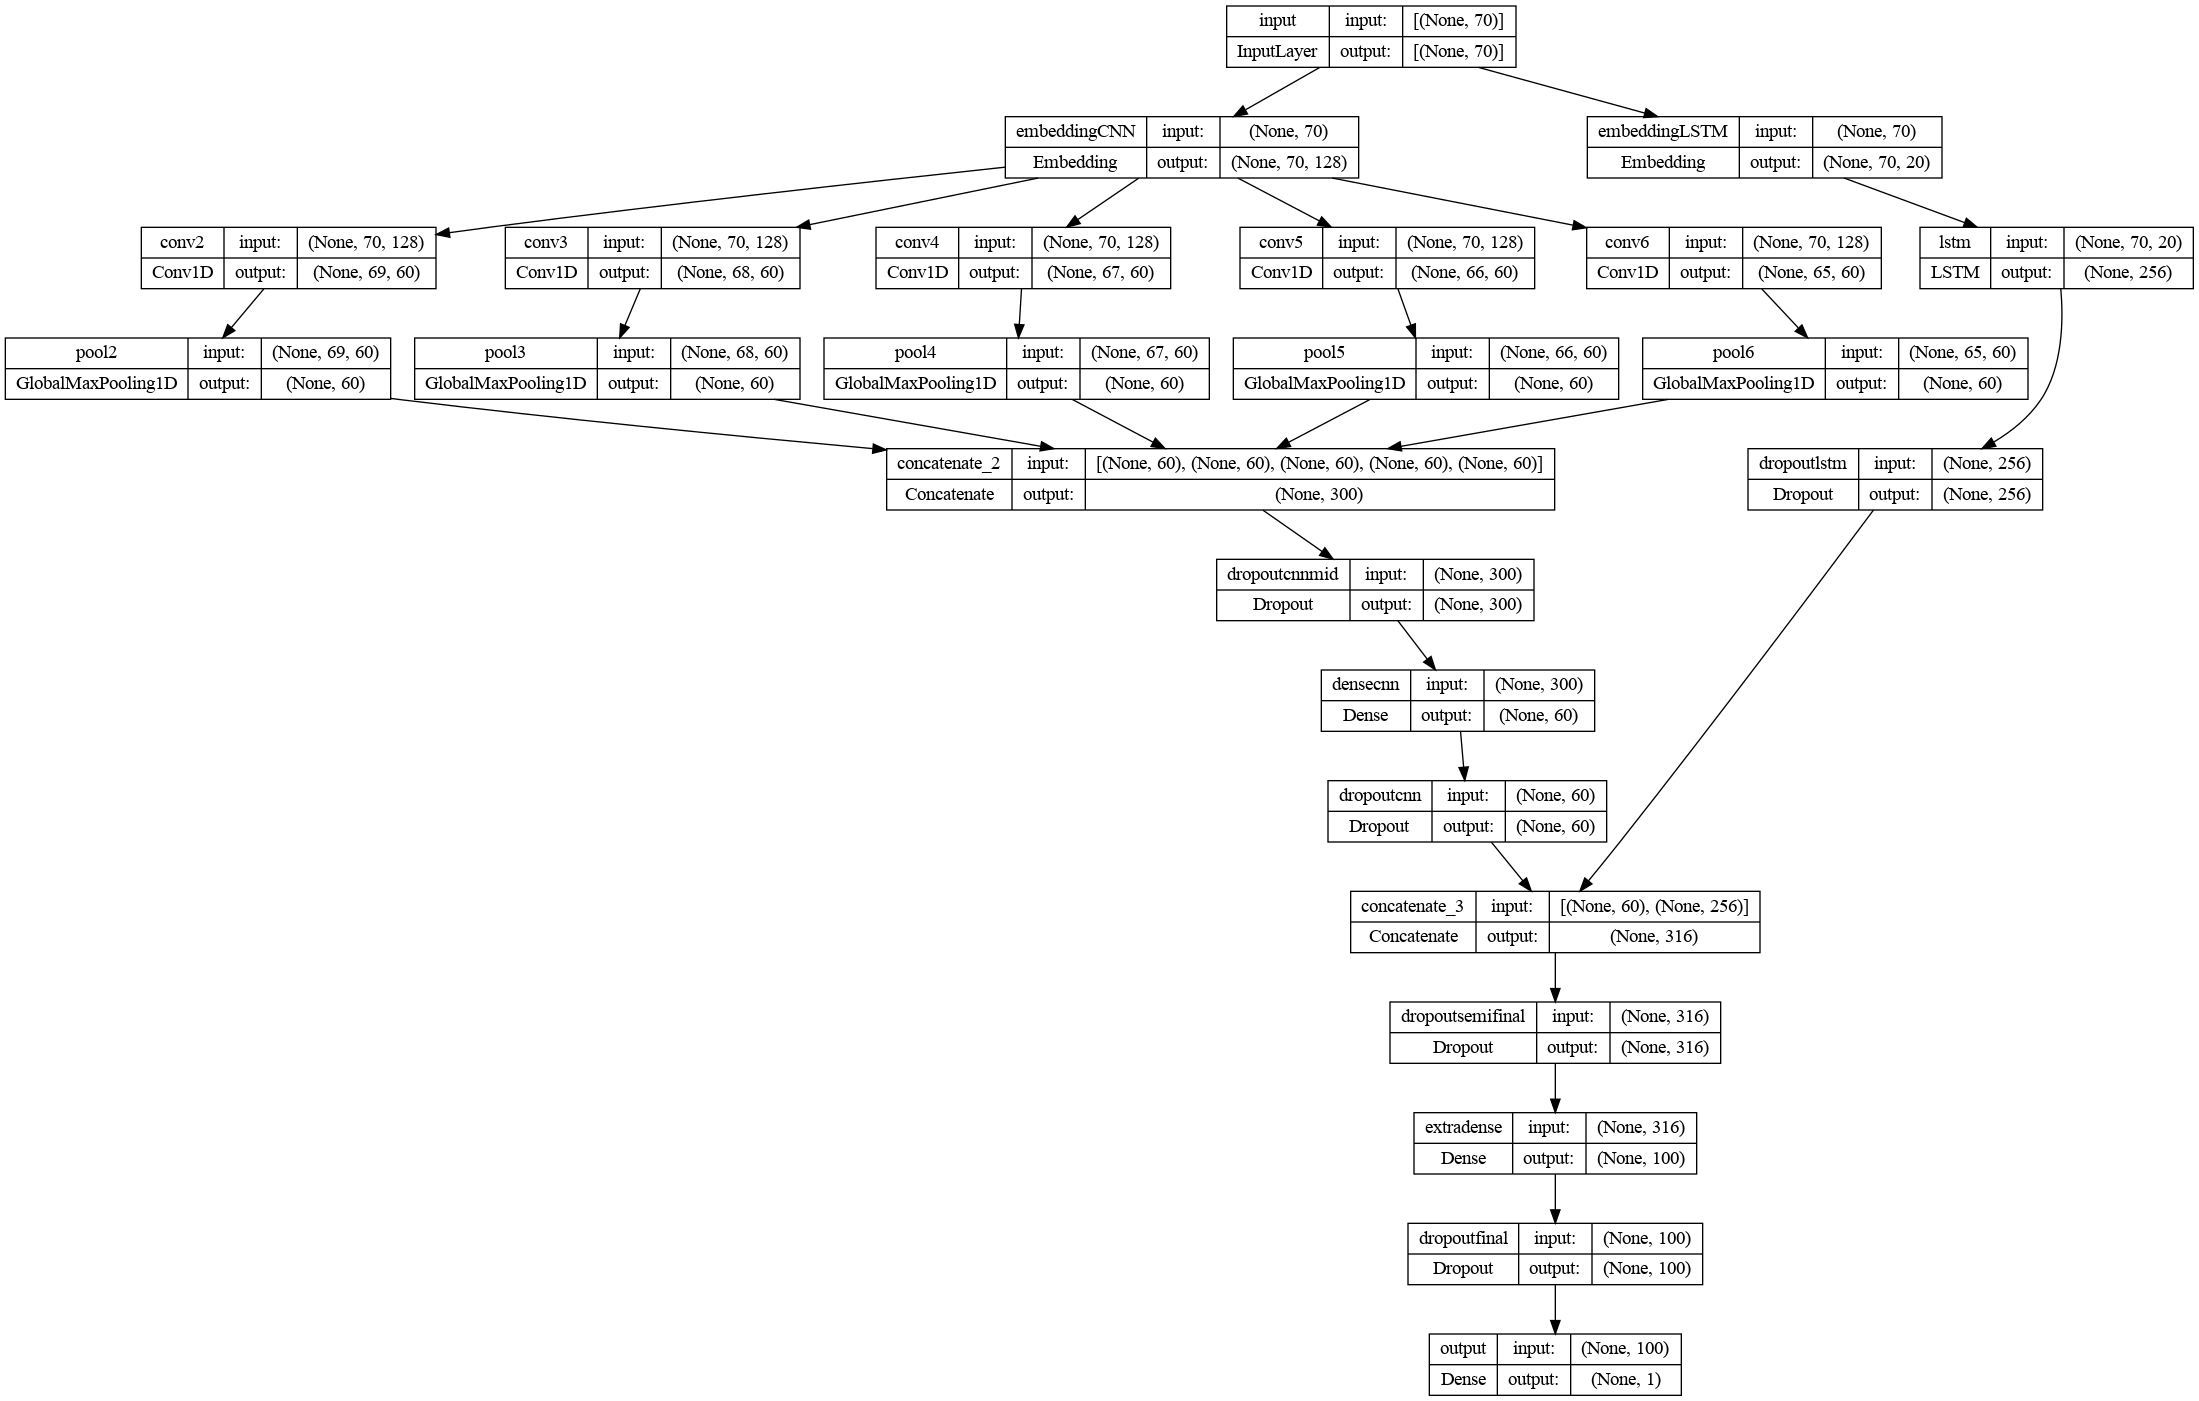

In [25]:
plot_model(model_bilbo, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [26]:
best_bilbo1 = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model_bilbo1',
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [28]:
model_bilbo.fit(X_train, y_train,
              epochs=10,
              validation_split = 0.1,
              callbacks = [best_bilbo1],
              batch_size=200)

Epoch 1/10


2024-04-10 11:03:01.379831: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.68GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


   4/7410 [..............................] - ETA: 2:15 - loss: 0.6922 - accuracy: 0.5050   

2024-04-10 11:03:01.852912: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.68GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


7410/7410 [==============================] - ETA: 0s - loss: 0.3149 - accuracy: 0.8530INFO:tensorflow:Assets written to: best_model_bilbo1/assets


INFO:tensorflow:Assets written to: best_model_bilbo1/assets


7410/7410 [==============================] - 145s 19ms/step - loss: 0.3149 - accuracy: 0.8530 - val_loss: 0.2431 - val_accuracy: 0.9009
Epoch 2/10
7408/7410 [============================>.] - ETA: 0s - loss: 0.2289 - accuracy: 0.9080INFO:tensorflow:Assets written to: best_model_bilbo1/assets


INFO:tensorflow:Assets written to: best_model_bilbo1/assets


7410/7410 [==============================] - 142s 19ms/step - loss: 0.2289 - accuracy: 0.9080 - val_loss: 0.2044 - val_accuracy: 0.9176
Epoch 3/10
7408/7410 [============================>.] - ETA: 0s - loss: 0.2000 - accuracy: 0.9214INFO:tensorflow:Assets written to: best_model_bilbo1/assets


INFO:tensorflow:Assets written to: best_model_bilbo1/assets


7410/7410 [==============================] - 142s 19ms/step - loss: 0.2000 - accuracy: 0.9214 - val_loss: 0.1776 - val_accuracy: 0.9310
Epoch 4/10
7408/7410 [============================>.] - ETA: 0s - loss: 0.1792 - accuracy: 0.9310INFO:tensorflow:Assets written to: best_model_bilbo1/assets


INFO:tensorflow:Assets written to: best_model_bilbo1/assets


7410/7410 [==============================] - 143s 19ms/step - loss: 0.1792 - accuracy: 0.9310 - val_loss: 0.1619 - val_accuracy: 0.9366
Epoch 5/10
7408/7410 [============================>.] - ETA: 0s - loss: 0.1639 - accuracy: 0.9373INFO:tensorflow:Assets written to: best_model_bilbo1/assets


INFO:tensorflow:Assets written to: best_model_bilbo1/assets


7410/7410 [==============================] - 142s 19ms/step - loss: 0.1639 - accuracy: 0.9373 - val_loss: 0.1522 - val_accuracy: 0.9402
Epoch 6/10
7408/7410 [============================>.] - ETA: 0s - loss: 0.1519 - accuracy: 0.9419INFO:tensorflow:Assets written to: best_model_bilbo1/assets


INFO:tensorflow:Assets written to: best_model_bilbo1/assets


7410/7410 [==============================] - 142s 19ms/step - loss: 0.1519 - accuracy: 0.9419 - val_loss: 0.1377 - val_accuracy: 0.9471
Epoch 7/10
7408/7410 [============================>.] - ETA: 0s - loss: 0.1433 - accuracy: 0.9454INFO:tensorflow:Assets written to: best_model_bilbo1/assets


INFO:tensorflow:Assets written to: best_model_bilbo1/assets


7410/7410 [==============================] - 142s 19ms/step - loss: 0.1433 - accuracy: 0.9454 - val_loss: 0.1313 - val_accuracy: 0.9496
Epoch 8/10
7410/7410 [==============================] - 140s 19ms/step - loss: 0.1356 - accuracy: 0.9487 - val_loss: 0.1296 - val_accuracy: 0.9477
Epoch 9/10
7408/7410 [============================>.] - ETA: 0s - loss: 0.1286 - accuracy: 0.9515INFO:tensorflow:Assets written to: best_model_bilbo1/assets


INFO:tensorflow:Assets written to: best_model_bilbo1/assets


7410/7410 [==============================] - 142s 19ms/step - loss: 0.1286 - accuracy: 0.9515 - val_loss: 0.1224 - val_accuracy: 0.9528
Epoch 10/10
7407/7410 [============================>.] - ETA: 0s - loss: 0.1224 - accuracy: 0.9541INFO:tensorflow:Assets written to: best_model_bilbo1/assets


INFO:tensorflow:Assets written to: best_model_bilbo1/assets


7410/7410 [==============================] - 142s 19ms/step - loss: 0.1224 - accuracy: 0.9541 - val_loss: 0.1186 - val_accuracy: 0.9552


In [29]:
model_bilbo = tf.keras.models.load_model('best_model_bilbo1')

In [30]:
predictions = model_bilbo.predict(X_test)
predictions = np.where(predictions > 0.5, 1, 0)

print('Matriz de Confusão')
print(confusion_matrix(y_test,predictions))

print('Relatório de Classificação')
print(classification_report(y_test,predictions, digits=4))

22052/22052 [==============================] - 49s 2ms/step
Matriz de Confusão
[[286579  13242]
 [ 18415 387427]]
Relatório de Classificação
              precision    recall  f1-score   support

           0     0.9396    0.9558    0.9477    299821
           1     0.9670    0.9546    0.9607    405842

    accuracy                         0.9551    705663
   macro avg     0.9533    0.9552    0.9542    705663
weighted avg     0.9553    0.9551    0.9552    705663



## Adversarial CNN+LSTM

In [34]:
hidden_dims=128
nb_filter = 64
filter_length =5 
embedding_vecor_length = 128
pool_length=4
lstm_output_size = 70



model_cnn_lstm = tf.keras.Sequential()
model_cnn_lstm.add(layers.Embedding(256, 60, input_length=70))
model_cnn_lstm.add(layers.Conv1D(filters=nb_filter, kernel_size=filter_length, activation='relu'))
model_cnn_lstm.add(layers.MaxPooling1D(pool_length))
model_cnn_lstm.add(layers.LSTM(lstm_output_size))
model_cnn_lstm.add(layers.Dense(1))
model_cnn_lstm.add(layers.Activation('sigmoid'))

model_cnn_lstm.compile(optimizer = opt, loss = 'binary_crossentropy', metrics='accuracy')
model_cnn_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 70, 60)            15360     
                                                                 
 conv1d_7 (Conv1D)           (None, 66, 64)            19264     
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 16, 64)            0         
 g1D)                                                            
                                                                 
 lstm_1 (LSTM)               (None, 70)                37800     
                                                                 
 dense_3 (Dense)             (None, 1)                 71        
                                                                 
 activation_1 (Activation)   (None, 1)                 0         
                                                      

In [35]:
best_cnn_lstm = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model_cnn_lstm1',
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [36]:
model_cnn_lstm.fit(X_train, y_train,
              epochs=10,
              validation_split = 0.1,
              callbacks = [best_cnn_lstm],
              batch_size=200)

Epoch 1/10
7410/7410 [==============================] - ETA: 0s - loss: 0.1490 - accuracy: 0.9422INFO:tensorflow:Assets written to: best_model_cnn_lstm1/assets


INFO:tensorflow:Assets written to: best_model_cnn_lstm1/assets


7410/7410 [==============================] - 31s 4ms/step - loss: 0.1490 - accuracy: 0.9422 - val_loss: 0.1192 - val_accuracy: 0.9545
Epoch 2/10
7396/7410 [============================>.] - ETA: 0s - loss: 0.1087 - accuracy: 0.9587INFO:tensorflow:Assets written to: best_model_cnn_lstm1/assets


INFO:tensorflow:Assets written to: best_model_cnn_lstm1/assets


7410/7410 [==============================] - 29s 4ms/step - loss: 0.1087 - accuracy: 0.9587 - val_loss: 0.1027 - val_accuracy: 0.9610
Epoch 3/10
7409/7410 [============================>.] - ETA: 0s - loss: 0.0984 - accuracy: 0.9628INFO:tensorflow:Assets written to: best_model_cnn_lstm1/assets


INFO:tensorflow:Assets written to: best_model_cnn_lstm1/assets


7410/7410 [==============================] - 28s 4ms/step - loss: 0.0984 - accuracy: 0.9628 - val_loss: 0.0960 - val_accuracy: 0.9638
Epoch 4/10
7409/7410 [============================>.] - ETA: 0s - loss: 0.0930 - accuracy: 0.9648INFO:tensorflow:Assets written to: best_model_cnn_lstm1/assets


INFO:tensorflow:Assets written to: best_model_cnn_lstm1/assets


7410/7410 [==============================] - 29s 4ms/step - loss: 0.0930 - accuracy: 0.9648 - val_loss: 0.0922 - val_accuracy: 0.9653
Epoch 5/10
7408/7410 [============================>.] - ETA: 0s - loss: 0.0895 - accuracy: 0.9662INFO:tensorflow:Assets written to: best_model_cnn_lstm1/assets


INFO:tensorflow:Assets written to: best_model_cnn_lstm1/assets


7410/7410 [==============================] - 29s 4ms/step - loss: 0.0895 - accuracy: 0.9662 - val_loss: 0.0917 - val_accuracy: 0.9654
Epoch 6/10
7399/7410 [============================>.] - ETA: 0s - loss: 0.0865 - accuracy: 0.9674INFO:tensorflow:Assets written to: best_model_cnn_lstm1/assets


INFO:tensorflow:Assets written to: best_model_cnn_lstm1/assets


7410/7410 [==============================] - 29s 4ms/step - loss: 0.0865 - accuracy: 0.9674 - val_loss: 0.0881 - val_accuracy: 0.9667
Epoch 7/10
7406/7410 [============================>.] - ETA: 0s - loss: 0.0841 - accuracy: 0.9684INFO:tensorflow:Assets written to: best_model_cnn_lstm1/assets


INFO:tensorflow:Assets written to: best_model_cnn_lstm1/assets


7410/7410 [==============================] - 28s 4ms/step - loss: 0.0841 - accuracy: 0.9684 - val_loss: 0.0869 - val_accuracy: 0.9674
Epoch 8/10
7402/7410 [============================>.] - ETA: 0s - loss: 0.0822 - accuracy: 0.9691INFO:tensorflow:Assets written to: best_model_cnn_lstm1/assets


INFO:tensorflow:Assets written to: best_model_cnn_lstm1/assets


7410/7410 [==============================] - 29s 4ms/step - loss: 0.0822 - accuracy: 0.9690 - val_loss: 0.0859 - val_accuracy: 0.9679
Epoch 9/10
7408/7410 [============================>.] - ETA: 0s - loss: 0.0806 - accuracy: 0.9698INFO:tensorflow:Assets written to: best_model_cnn_lstm1/assets


INFO:tensorflow:Assets written to: best_model_cnn_lstm1/assets


7410/7410 [==============================] - 28s 4ms/step - loss: 0.0806 - accuracy: 0.9698 - val_loss: 0.0837 - val_accuracy: 0.9686
Epoch 10/10
7410/7410 [==============================] - ETA: 0s - loss: 0.0791 - accuracy: 0.9705INFO:tensorflow:Assets written to: best_model_cnn_lstm1/assets


INFO:tensorflow:Assets written to: best_model_cnn_lstm1/assets


7410/7410 [==============================] - 29s 4ms/step - loss: 0.0791 - accuracy: 0.9705 - val_loss: 0.0833 - val_accuracy: 0.9689


In [37]:
model_cnn_lstm = tf.keras.models.load_model('best_model_cnn_lstm1')

In [38]:
predictions = model_cnn_lstm.predict(X_test)
predictions = np.where(predictions > 0.5, 1, 0)

print('Matriz de Confusão')
print(confusion_matrix(y_test,predictions))

print('Relatório de Classificação')
print(classification_report(y_test,predictions, digits=4))

22052/22052 [==============================] - 20s 882us/step
Matriz de Confusão
[[291006   8815]
 [ 13046 392796]]
Relatório de Classificação
              precision    recall  f1-score   support

           0     0.9571    0.9706    0.9638    299821
           1     0.9781    0.9679    0.9729    405842

    accuracy                         0.9690    705663
   macro avg     0.9676    0.9692    0.9684    705663
weighted avg     0.9691    0.9690    0.9690    705663



## Adversarial RNN

In [15]:
model_rnn = tf.keras.Sequential()
model_rnn.add(layers.Embedding(256, 60, input_length=70))
model_rnn.add(layers.SimpleRNN(128))
model_rnn.add(layers.Dropout(0.1))
model_rnn.add(layers.Dense(1))
model_rnn.add(layers.Activation('sigmoid'))


model_rnn.compile(optimizer = opt, loss = 'binary_crossentropy', metrics='accuracy')
model_rnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 70, 60)            15360     
                                                                 
 simple_rnn (SimpleRNN)      (None, 128)               24192     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 39681 (155.00 KB)
Trainable params: 39681 (155.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
best_rnn = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model_rnn1',
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [17]:
model_rnn.fit(X_train, y_train,
              epochs=10,
              validation_split = 0.1,
              callbacks = [best_rnn],
              batch_size=200)

Epoch 1/10


2024-04-10 13:58:31.414846: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-04-10 13:58:31.425397: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x63992e5037c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-10 13:58:31.425413: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2024-04-10 13:58:31.429036: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-10 13:58:31.439150: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8902
2024-04-10 13:58:31.508802: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifeti

7408/7410 [============================>.] - ETA: 0s - loss: 0.2245 - accuracy: 0.9096INFO:tensorflow:Assets written to: best_model_rnn1/assets


INFO:tensorflow:Assets written to: best_model_rnn1/assets


7410/7410 [==============================] - 139s 19ms/step - loss: 0.2245 - accuracy: 0.9096 - val_loss: 0.1696 - val_accuracy: 0.9346
Epoch 2/10
7410/7410 [==============================] - ETA: 0s - loss: 0.1588 - accuracy: 0.9391INFO:tensorflow:Assets written to: best_model_rnn1/assets


INFO:tensorflow:Assets written to: best_model_rnn1/assets


7410/7410 [==============================] - 134s 18ms/step - loss: 0.1588 - accuracy: 0.9391 - val_loss: 0.1479 - val_accuracy: 0.9439
Epoch 3/10
7409/7410 [============================>.] - ETA: 0s - loss: 0.1418 - accuracy: 0.9459INFO:tensorflow:Assets written to: best_model_rnn1/assets


INFO:tensorflow:Assets written to: best_model_rnn1/assets


7410/7410 [==============================] - 134s 18ms/step - loss: 0.1418 - accuracy: 0.9459 - val_loss: 0.1297 - val_accuracy: 0.9508
Epoch 4/10
7408/7410 [============================>.] - ETA: 0s - loss: 0.1333 - accuracy: 0.9494INFO:tensorflow:Assets written to: best_model_rnn1/assets


INFO:tensorflow:Assets written to: best_model_rnn1/assets


7410/7410 [==============================] - 132s 18ms/step - loss: 0.1333 - accuracy: 0.9494 - val_loss: 0.1282 - val_accuracy: 0.9516
Epoch 5/10
7409/7410 [============================>.] - ETA: 0s - loss: 0.1276 - accuracy: 0.9516INFO:tensorflow:Assets written to: best_model_rnn1/assets


INFO:tensorflow:Assets written to: best_model_rnn1/assets


7410/7410 [==============================] - 132s 18ms/step - loss: 0.1276 - accuracy: 0.9516 - val_loss: 0.1228 - val_accuracy: 0.9529
Epoch 6/10
7410/7410 [==============================] - ETA: 0s - loss: 0.1231 - accuracy: 0.9535INFO:tensorflow:Assets written to: best_model_rnn1/assets


INFO:tensorflow:Assets written to: best_model_rnn1/assets


7410/7410 [==============================] - 137s 18ms/step - loss: 0.1231 - accuracy: 0.9535 - val_loss: 0.1221 - val_accuracy: 0.9533
Epoch 7/10
7410/7410 [==============================] - 135s 18ms/step - loss: 0.1195 - accuracy: 0.9549 - val_loss: 0.1367 - val_accuracy: 0.9478
Epoch 8/10
7408/7410 [============================>.] - ETA: 0s - loss: 0.1164 - accuracy: 0.9562INFO:tensorflow:Assets written to: best_model_rnn1/assets


INFO:tensorflow:Assets written to: best_model_rnn1/assets


7410/7410 [==============================] - 134s 18ms/step - loss: 0.1164 - accuracy: 0.9562 - val_loss: 0.1171 - val_accuracy: 0.9558
Epoch 9/10
7410/7410 [==============================] - ETA: 0s - loss: 0.1140 - accuracy: 0.9571INFO:tensorflow:Assets written to: best_model_rnn1/assets


INFO:tensorflow:Assets written to: best_model_rnn1/assets


7410/7410 [==============================] - 132s 18ms/step - loss: 0.1140 - accuracy: 0.9571 - val_loss: 0.1123 - val_accuracy: 0.9580
Epoch 10/10
7410/7410 [==============================] - ETA: 0s - loss: 0.1113 - accuracy: 0.9582INFO:tensorflow:Assets written to: best_model_rnn1/assets


INFO:tensorflow:Assets written to: best_model_rnn1/assets


7410/7410 [==============================] - 135s 18ms/step - loss: 0.1113 - accuracy: 0.9582 - val_loss: 0.1132 - val_accuracy: 0.9581


In [18]:
model_rnn = tf.keras.models.load_model('best_model_rnn1')

In [19]:
predictions = model_rnn.predict(X_test)
predictions = np.where(predictions > 0.5, 1, 0)

print('Matriz de Confusão')
print(confusion_matrix(y_test,predictions))

print('Relatório de Classificação')
print(classification_report(y_test,predictions, digits=4))

22052/22052 [==============================] - 87s 4ms/step
Matriz de Confusão
[[289658  10163]
 [ 19697 386145]]
Relatório de Classificação
              precision    recall  f1-score   support

           0     0.9363    0.9661    0.9510    299821
           1     0.9744    0.9515    0.9628    405842

    accuracy                         0.9577    705663
   macro avg     0.9553    0.9588    0.9569    705663
weighted avg     0.9582    0.9577    0.9578    705663



## Adversarial CNN

In [14]:
hidden_dims=128
nb_filter = 64
filter_length =5 
embedding_vecor_length = 128
pool_length=4
lstm_output_size = 70

model_cnn = tf.keras.Sequential()
model_cnn.add(layers.Embedding(256, 60, input_length=70))
model_cnn.add(layers.Conv1D(filters=nb_filter, kernel_size=filter_length, activation='relu'))
model_cnn.add(layers.GlobalMaxPooling1D())
model_cnn.add(layers.Dense(hidden_dims))
model_cnn.add(layers.Dropout(0.2))
model_cnn.add(layers.Activation('relu'))
model_cnn.add(layers.Dense(1))
model_cnn.add(layers.Activation('sigmoid'))

model_cnn.compile(optimizer = opt, loss = 'binary_crossentropy', metrics='accuracy')
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 70, 60)            15360     
                                                                 
 conv1d (Conv1D)             (None, 66, 64)            19264     
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 activation (Activation)     (None, 128)               0         
                                                        

In [15]:
best_cnn = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model_cnn1',
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [16]:
model_cnn.fit(X_train, y_train,
              epochs=10,
              validation_split = 0.1,
              callbacks = [best_cnn],
              batch_size=200)

Epoch 1/10


2024-04-10 14:31:14.405319: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8902
2024-04-10 14:31:14.541658: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-04-10 14:31:14.544370: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5b95064e6950 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-10 14:31:14.544384: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2024-04-10 14:31:14.548241: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-10 14:31:14.629067: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifeti

7410/7410 [==============================] - ETA: 0s - loss: 0.2187 - accuracy: 0.9097INFO:tensorflow:Assets written to: best_model_cnn1/assets


INFO:tensorflow:Assets written to: best_model_cnn1/assets


7410/7410 [==============================] - 23s 3ms/step - loss: 0.2187 - accuracy: 0.9097 - val_loss: 0.1541 - val_accuracy: 0.9379
Epoch 2/10
7395/7410 [============================>.] - ETA: 0s - loss: 0.1407 - accuracy: 0.9437INFO:tensorflow:Assets written to: best_model_cnn1/assets


INFO:tensorflow:Assets written to: best_model_cnn1/assets


7410/7410 [==============================] - 18s 2ms/step - loss: 0.1407 - accuracy: 0.9437 - val_loss: 0.1301 - val_accuracy: 0.9479
Epoch 3/10
7406/7410 [============================>.] - ETA: 0s - loss: 0.1238 - accuracy: 0.9506INFO:tensorflow:Assets written to: best_model_cnn1/assets


INFO:tensorflow:Assets written to: best_model_cnn1/assets


7410/7410 [==============================] - 18s 2ms/step - loss: 0.1238 - accuracy: 0.9506 - val_loss: 0.1186 - val_accuracy: 0.9529
Epoch 4/10
7407/7410 [============================>.] - ETA: 0s - loss: 0.1152 - accuracy: 0.9542INFO:tensorflow:Assets written to: best_model_cnn1/assets


INFO:tensorflow:Assets written to: best_model_cnn1/assets


7410/7410 [==============================] - 18s 2ms/step - loss: 0.1152 - accuracy: 0.9542 - val_loss: 0.1127 - val_accuracy: 0.9553
Epoch 5/10
7408/7410 [============================>.] - ETA: 0s - loss: 0.1095 - accuracy: 0.9567INFO:tensorflow:Assets written to: best_model_cnn1/assets


INFO:tensorflow:Assets written to: best_model_cnn1/assets


7410/7410 [==============================] - 18s 2ms/step - loss: 0.1095 - accuracy: 0.9567 - val_loss: 0.1097 - val_accuracy: 0.9564
Epoch 6/10
7409/7410 [============================>.] - ETA: 0s - loss: 0.1052 - accuracy: 0.9586INFO:tensorflow:Assets written to: best_model_cnn1/assets


INFO:tensorflow:Assets written to: best_model_cnn1/assets


7410/7410 [==============================] - 18s 2ms/step - loss: 0.1052 - accuracy: 0.9586 - val_loss: 0.1057 - val_accuracy: 0.9584
Epoch 7/10
7409/7410 [============================>.] - ETA: 0s - loss: 0.1022 - accuracy: 0.9599INFO:tensorflow:Assets written to: best_model_cnn1/assets


INFO:tensorflow:Assets written to: best_model_cnn1/assets


7410/7410 [==============================] - 18s 2ms/step - loss: 0.1022 - accuracy: 0.9599 - val_loss: 0.1035 - val_accuracy: 0.9591
Epoch 8/10
7403/7410 [============================>.] - ETA: 0s - loss: 0.0997 - accuracy: 0.9609INFO:tensorflow:Assets written to: best_model_cnn1/assets


INFO:tensorflow:Assets written to: best_model_cnn1/assets


7410/7410 [==============================] - 18s 2ms/step - loss: 0.0997 - accuracy: 0.9609 - val_loss: 0.1021 - val_accuracy: 0.9597
Epoch 9/10
7388/7410 [============================>.] - ETA: 0s - loss: 0.0974 - accuracy: 0.9618INFO:tensorflow:Assets written to: best_model_cnn1/assets


INFO:tensorflow:Assets written to: best_model_cnn1/assets


7410/7410 [==============================] - 18s 2ms/step - loss: 0.0974 - accuracy: 0.9618 - val_loss: 0.1007 - val_accuracy: 0.9601
Epoch 10/10
7397/7410 [============================>.] - ETA: 0s - loss: 0.0956 - accuracy: 0.9627INFO:tensorflow:Assets written to: best_model_cnn1/assets


INFO:tensorflow:Assets written to: best_model_cnn1/assets


7410/7410 [==============================] - 18s 2ms/step - loss: 0.0956 - accuracy: 0.9627 - val_loss: 0.1003 - val_accuracy: 0.9605


In [17]:
model_cnn = tf.keras.models.load_model('best_model_cnn1')

In [18]:
predictions = model_cnn.predict(X_test)
predictions = np.where(predictions > 0.5, 1, 0)

print('Matriz de Confusão')
print(confusion_matrix(y_test,predictions))

print('Relatório de Classificação')
print(classification_report(y_test,predictions, digits=4))

22052/22052 [==============================] - 13s 585us/step
Matriz de Confusão
[[290088   9733]
 [ 17524 388318]]
Relatório de Classificação
              precision    recall  f1-score   support

           0     0.9430    0.9675    0.9551    299821
           1     0.9755    0.9568    0.9661    405842

    accuracy                         0.9614    705663
   macro avg     0.9593    0.9622    0.9606    705663
weighted avg     0.9617    0.9614    0.9614    705663



## DistilBERT Tokenizer + DNN

In [10]:
df_test = df_test.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)

In [11]:
import transformers
tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [12]:
X_train = df_train['domain']
y_train = df_train['label']
y_train = y_train.to_numpy()

In [13]:
X_test = df_test['domain']
y_test = df_test['label']
y_test = y_test.to_numpy()

In [14]:
X_train_tk = [tokenizer(text, padding='max_length', max_length = 10, truncation=True)['input_ids'] for text in X_train]
X_train_tk = np.array(X_train_tk, dtype='int32')

In [15]:
X_test_tk = [tokenizer(text, padding='max_length', max_length = 10, truncation=True)['input_ids'] for text in X_test]
X_test_tk = np.array(X_test_tk, dtype='int32')

In [16]:
config = transformers.DistilBertConfig(dropout=0.2, attention_dropout=0.2)
dbert_tf = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased', config=config, trainable=False)

2024-04-13 16:26:56.179131: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-13 16:26:56.201720: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-13 16:26:56.201941: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [17]:
X_test_tk[2]

array([  101,  1023,  2278,  2546,  2575,  2497,  2683, 24594,  2683,
         102], dtype=int32)

In [18]:
input_ids_in = layers.Input(shape=(10,), name='input_token', dtype='int32')

x = dbert_tf(input_ids=input_ids_in)[0][:,0,:]
x = layers.Dropout(0.2, name='dropout')(x)
x = layers.Dense(64, activation='relu', name='dense')(x)
x = layers.Dense(1, activation='sigmoid', name='classification')(x)

model_bert = tf.keras.Model(inputs=input_ids_in, outputs = x, name='ClassificationModelTF')

model_bert.compile(optimizer='adam',loss='binary_crossentropy', metrics='accuracy')
model_bert.summary()

Model: "ClassificationModelTF"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_token (InputLayer)    [(None, 10)]              0         
                                                                 
 tf_distil_bert_model (TFDi  TFBaseModelOutput(last_   66362880  
 stilBertModel)              hidden_state=(None, 10,             
                              768),                              
                              hidden_states=None, at             
                             tentions=None)                      
                                                                 
 tf.__operators__.getitem (  (None, 768)               0         
 SlicingOpLambda)                                                
                                                                 
 dropout (Dropout)           (None, 768)               0         
                                             

In [19]:
best_bert = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model_bert1',
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [20]:
model_bert.fit(X_train_tk, y_train,
              epochs=10,
              validation_split = 0.1,
              callbacks = [best_bert],
              batch_size=200)

Epoch 1/10


2024-04-13 16:27:03.917428: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x70841c0509f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-13 16:27:03.917446: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2024-04-13 16:27:03.921262: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-13 16:27:03.932295: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8902
2024-04-13 16:27:04.017982: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


7409/7410 [============================>.] - ETA: 0s - loss: 0.2349 - accuracy: 0.8985WARNING:tensorflow:Skipping full serialization of Keras layer <keras.src.layers.regularization.dropout.Dropout object at 0x708694c10bb0>, because it is not built.
INFO:tensorflow:Assets written to: best_model_bert1/assets


INFO:tensorflow:Assets written to: best_model_bert1/assets


7410/7410 [==============================] - 525s 70ms/step - loss: 0.2349 - accuracy: 0.8985 - val_loss: 0.1666 - val_accuracy: 0.9340
Epoch 2/10
7409/7410 [============================>.] - ETA: 0s - loss: 0.2090 - accuracy: 0.9104WARNING:tensorflow:Skipping full serialization of Keras layer <keras.src.layers.regularization.dropout.Dropout object at 0x708694c10bb0>, because it is not built.


INFO:tensorflow:Assets written to: best_model_bert1/assets


INFO:tensorflow:Assets written to: best_model_bert1/assets


7410/7410 [==============================] - 524s 71ms/step - loss: 0.2090 - accuracy: 0.9104 - val_loss: 0.1523 - val_accuracy: 0.9383
Epoch 3/10
7409/7410 [============================>.] - ETA: 0s - loss: 0.2024 - accuracy: 0.9132WARNING:tensorflow:Skipping full serialization of Keras layer <keras.src.layers.regularization.dropout.Dropout object at 0x708694c10bb0>, because it is not built.


INFO:tensorflow:Assets written to: best_model_bert1/assets


INFO:tensorflow:Assets written to: best_model_bert1/assets


7410/7410 [==============================] - 524s 71ms/step - loss: 0.2024 - accuracy: 0.9132 - val_loss: 0.1506 - val_accuracy: 0.9403
Epoch 4/10
7409/7410 [============================>.] - ETA: 0s - loss: 0.1974 - accuracy: 0.9156WARNING:tensorflow:Skipping full serialization of Keras layer <keras.src.layers.regularization.dropout.Dropout object at 0x708694c10bb0>, because it is not built.


INFO:tensorflow:Assets written to: best_model_bert1/assets


INFO:tensorflow:Assets written to: best_model_bert1/assets


7410/7410 [==============================] - 524s 71ms/step - loss: 0.1974 - accuracy: 0.9156 - val_loss: 0.1464 - val_accuracy: 0.9410
Epoch 5/10
7409/7410 [============================>.] - ETA: 0s - loss: 0.1945 - accuracy: 0.9166WARNING:tensorflow:Skipping full serialization of Keras layer <keras.src.layers.regularization.dropout.Dropout object at 0x708694c10bb0>, because it is not built.


INFO:tensorflow:Assets written to: best_model_bert1/assets


INFO:tensorflow:Assets written to: best_model_bert1/assets


7410/7410 [==============================] - 524s 71ms/step - loss: 0.1945 - accuracy: 0.9166 - val_loss: 0.1415 - val_accuracy: 0.9431
Epoch 6/10
7410/7410 [==============================] - 515s 69ms/step - loss: 0.1920 - accuracy: 0.9178 - val_loss: 0.1502 - val_accuracy: 0.9378
Epoch 7/10
7409/7410 [============================>.] - ETA: 0s - loss: 0.1903 - accuracy: 0.9182WARNING:tensorflow:Skipping full serialization of Keras layer <keras.src.layers.regularization.dropout.Dropout object at 0x708694c10bb0>, because it is not built.


INFO:tensorflow:Assets written to: best_model_bert1/assets


INFO:tensorflow:Assets written to: best_model_bert1/assets


7410/7410 [==============================] - 525s 71ms/step - loss: 0.1903 - accuracy: 0.9182 - val_loss: 0.1383 - val_accuracy: 0.9447
Epoch 8/10
7409/7410 [============================>.] - ETA: 0s - loss: 0.1887 - accuracy: 0.9195WARNING:tensorflow:Skipping full serialization of Keras layer <keras.src.layers.regularization.dropout.Dropout object at 0x708694c10bb0>, because it is not built.


INFO:tensorflow:Assets written to: best_model_bert1/assets


INFO:tensorflow:Assets written to: best_model_bert1/assets


7410/7410 [==============================] - 525s 71ms/step - loss: 0.1887 - accuracy: 0.9195 - val_loss: 0.1370 - val_accuracy: 0.9453
Epoch 9/10
7410/7410 [==============================] - 514s 69ms/step - loss: 0.1879 - accuracy: 0.9195 - val_loss: 0.1394 - val_accuracy: 0.9435
Epoch 10/10
7409/7410 [============================>.] - ETA: 0s - loss: 0.1865 - accuracy: 0.9201WARNING:tensorflow:Skipping full serialization of Keras layer <keras.src.layers.regularization.dropout.Dropout object at 0x708694c10bb0>, because it is not built.


INFO:tensorflow:Assets written to: best_model_bert1/assets


INFO:tensorflow:Assets written to: best_model_bert1/assets


7410/7410 [==============================] - 524s 71ms/step - loss: 0.1865 - accuracy: 0.9201 - val_loss: 0.1343 - val_accuracy: 0.9464


In [21]:
predictions = model_bert.predict(X_test_tk)
predictions = np.where(predictions > 0.5, 1, 0)

print('Matriz de Confusão')
print(confusion_matrix(y_test,predictions))

print('Relatório de Classificação')
print(classification_report(y_test,predictions, digits=4))

22052/22052 [==============================] - 374s 17ms/step
Matriz de Confusão
[[282834  16987]
 [ 20793 385049]]
Relatório de Classificação
              precision    recall  f1-score   support

           0     0.9315    0.9433    0.9374    299821
           1     0.9577    0.9488    0.9532    405842

    accuracy                         0.9465    705663
   macro avg     0.9446    0.9461    0.9453    705663
weighted avg     0.9466    0.9465    0.9465    705663



In [22]:
model_bert.save_weights('best_model_bert1_weights')